In [93]:
import pandas as pd
import numpy as np
import data_preprocess as dp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

In [94]:
# set decimal places to 4
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [95]:
data = pd.read_csv('./data/D2.csv')

In [96]:
df = dp.data_prep(data, verbose=True)

Running drop_columns_with_missing_values...
Running recode_medical_specialty...
Running recode_admission_type...
Running recode_discharge_disposition...
Running recode_admission_source...
Running recode_binary_values...
Running recode_drug_columns...
Running recode_age_column...
Running drop_deceased_patients...
Data preparation complete.


In [97]:
rs = 42

In [98]:
# Step 1: Separating the features and target variable
X = df.drop('readmitted', axis=1)  # Features
y = df['readmitted']  # Target variable  


In [99]:
# Identifying categorical columns that need encoding
categorical_columns = ['race', 'medical_specialty', 'admission_type', 'discharge_disposition', 'admission_source']
numerical_columns = ['gender', 'age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
                     'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses',
                     'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
                     'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'insulin', 'change', 'diabetesMed']

In [100]:
label_encoder = LabelEncoder()
X['age'] = label_encoder.fit_transform(X['age'])

In [101]:
X = pd.get_dummies(X, columns=categorical_columns, dtype=int)

In [102]:
scaler = MinMaxScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])


In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=rs)

In [104]:
# Import the model
from sklearn.linear_model import LogisticRegression

# Instantiate the default model
base_model = LogisticRegression(random_state=rs, max_iter=2000)
base_model.fit(X_train, y_train)

LogisticRegression(max_iter=2000, random_state=42)

In [105]:
# perform cross validation with gridsearchCV
from sklearn.model_selection import GridSearchCV


In [106]:
# defining the hyperparameters
params = {
    'C': [pow(10, x) for x in range(-4, 6)],
}

In [107]:
# Instantiating the gridsearch
grid_model = GridSearchCV(param_grid=params, estimator=base_model, return_train_score=True, cv=10, n_jobs=-1, verbose=1)
grid_model.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


GridSearchCV(cv=10,
             estimator=LogisticRegression(max_iter=2000, random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                               10000, 100000]},
             return_train_score=True, verbose=1)

In [108]:
# best accuracy score
y_pred_grid = grid_model.predict(X_test)
grid_accuracy = accuracy_score(y_test, y_pred_grid)
grid_classification_report = classification_report(y_test, y_pred_grid)

In [109]:
best_params = grid_model.best_params_

In [110]:
print(grid_accuracy)
print(grid_classification_report)
print(best_params)

0.6303353658536586
              precision    recall  f1-score   support

           0       0.62      0.78      0.69      2068
           1       0.65      0.47      0.55      1868

    accuracy                           0.63      3936
   macro avg       0.64      0.62      0.62      3936
weighted avg       0.64      0.63      0.62      3936

{'C': 100000}


In [111]:
grid_search = LogisticRegression(C=0.1, random_state=1, max_iter=2000)
grid_search.fit(X_train, y_train)

# Get feature importances (coefficients) from the logistic regression model
importance = grid_search.coef_[0]

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
})

top_5_features = feature_importance_df.reindex(
    feature_importance_df['Importance'].abs().sort_values(ascending=False).index).head(5)
top_5_features

,Feature,Importance
8,number_inpatient,4.5147
6,number_outpatient,1.2822
7,number_emergency,0.8497
5,num_medications,0.6663
9,number_diagnoses,0.5744


In [112]:
# Training and test accuracy
from sklearn.metrics import accuracy_score

# Predict on the training and test sets
y_train_pred = grid_model.best_estimator_.predict(X_train)
y_test_pred = grid_model.best_estimator_.predict(X_test)

# Calculate training and test accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the accuracy scores
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.6328
Test Accuracy: 0.6303


In [113]:
from sklearn.feature_selection import RFECV

In [114]:
rfecv = RFECV(estimator=grid_search, cv=10, n_jobs=-1, verbose=1, scoring='accuracy')
rfecv.fit(X_train, y_train)

Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 fe

RFECV(cv=10, estimator=LogisticRegression(C=0.1, max_iter=2000, random_state=1),
      n_jobs=-1, scoring='accuracy', verbose=1)

In [115]:
print(f"Original feature set: {X_train.shape[1]}")
print(f"Optimal number of features : {rfecv.n_features_}")

Original feature set: 42
Optimal number of features : 14


In [116]:
X_train_rfecv = rfecv.transform(X_train)
X_test_rfecv = rfecv.transform(X_test)

In [117]:
grid_model_rfecv = GridSearchCV(estimator=grid_search, param_grid=params,  cv=5, scoring='accuracy')
grid_model_rfecv.fit(X_train_rfecv, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(C=0.1, max_iter=2000, random_state=1),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                               10000, 100000]},
             scoring='accuracy')

In [118]:
y_pred_rfecv = grid_model_rfecv.predict(X_test_rfecv)
rfecv_accuracy = accuracy_score(y_test, y_pred_rfecv)
rfecv_classification_report = classification_report(y_test, y_pred_rfecv)

In [119]:
best_params_rfecv = grid_model_rfecv.best_params_
best_params_rfecv

{'C': 100000}

In [120]:
print(rfecv_accuracy)
print(rfecv_classification_report)
print(best_params_rfecv)

0.6308434959349594
              precision    recall  f1-score   support

           0       0.62      0.79      0.69      2068
           1       0.66      0.45      0.54      1868

    accuracy                           0.63      3936
   macro avg       0.64      0.62      0.62      3936
weighted avg       0.64      0.63      0.62      3936

{'C': 100000}


In [121]:
# Get the boolean mask of selected features from the RFECV model
selected_features_mask = rfecv.support_

# Get the names of the selected features
selected_features = X.columns[selected_features_mask]

# Get the coefficients of the final tuned logistic regression model
coefficients = grid_model_rfecv.best_estimator_.coef_[0]

# Create a dataframe of the selected features and their corresponding coefficients
important_features_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': coefficients
})

# Sort the features by absolute importance and get the top 5
top_5_features_rfecv = important_features_df.reindex(important_features_df['Importance'].abs().sort_values(ascending=False).index).head(5)
top_5_features_rfecv


,Feature,Importance
3,number_emergency,15.5110
4,number_inpatient,7.8820
2,number_outpatient,3.5925
1,num_medications,0.8169
5,number_diagnoses,0.5590


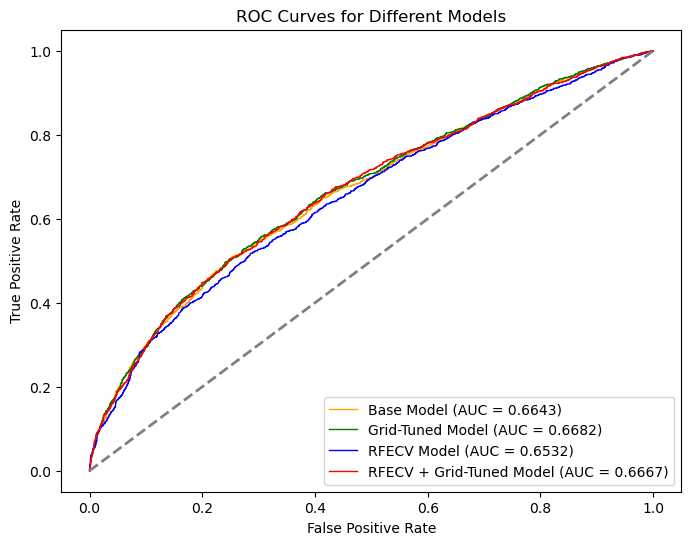

In [122]:
# Now, compute the ROC curves for all four models
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Base model
y_score_base = base_model.decision_function(X_test)
fpr_base, tpr_base, _ = roc_curve(y_test, y_score_base)
roc_auc_base = auc(fpr_base, tpr_base)

# Grid-tuned model
y_score_grid = grid_model.decision_function(X_test)
fpr_grid, tpr_grid, _ = roc_curve(y_test, y_score_grid)
roc_auc_grid = auc(fpr_grid, tpr_grid)

# RFECV model
y_score_rfecv = rfecv.estimator_.decision_function(X_test_rfecv)
fpr_rfecv, tpr_rfecv, _ = roc_curve(y_test, y_score_rfecv)
roc_auc_rfecv = auc(fpr_rfecv, tpr_rfecv)

# RFECV + Grid-tuned model
y_score_grid_rfecv = grid_model_rfecv.decision_function(X_test_rfecv)
fpr_grid_rfecv, tpr_grid_rfecv, _ = roc_curve(y_test, y_score_grid_rfecv)
roc_auc_grid_rfecv = auc(fpr_grid_rfecv, tpr_grid_rfecv)

# Plotting the ROC curves for all models
plt.figure(figsize=(8, 6))

plt.plot(fpr_base, tpr_base, color='orange', lw=1, label=f'Base Model (AUC = {roc_auc_base:.4f})')
plt.plot(fpr_grid, tpr_grid, color='green', lw=1, label=f'Grid-Tuned Model (AUC = {roc_auc_grid:.4f})')
plt.plot(fpr_rfecv, tpr_rfecv, color='blue', lw=1, label=f'RFECV Model (AUC = {roc_auc_rfecv:.4f})')
plt.plot(fpr_grid_rfecv, tpr_grid_rfecv, color='red', lw=1, label=f'RFECV + Grid-Tuned Model (AUC = {roc_auc_grid_rfecv:.4f})')

# Plot diagonal line for reference (random guessing)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend(loc="lower right")

# Show plot
plt.show()



In [123]:
# Assuming you have trained a logistic regression model
feature_names = X.columns  # Names of the features
coefficients = grid_search.coef_[0]  # Coefficients from the logistic regression model

# Combine feature names and coefficients into a readable format
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort by the magnitude of importance
feature_importance['Importance'] = np.abs(feature_importance['Coefficient'])
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)

# View the top influential features
print(feature_importance.head(10))

                       Feature  Coefficient  Importance
8             number_inpatient       4.5147      4.5147
6            number_outpatient       1.2822      1.2822
7             number_emergency       0.8497      0.8497
5              num_medications       0.6663      0.6663
9             number_diagnoses       0.5744      0.5744
40   admission_source_Transfer      -0.3232      0.3232
10                   metformin      -0.3160      0.3160
1                          age       0.3159      0.3159
21                 diabetesMed       0.2824      0.2824
38  admission_source_Emergency       0.2377      0.2377
